<a href="https://colab.research.google.com/github/lonanni/WaterNets/blob/main/CloudWaterMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of how to define the Water and Cloud Masks for LandSat8 data

In [1]:
!pip -q install geemap rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [2]:
import ee
import glob
import os
import geemap.foliumap as emap
import rasterio
import logging
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
logging.getLogger('rasterio').setLevel(logging.ERROR)

from pyproj import Geod

In [3]:
class EarthEngineDownloader:
  """
  Initialize the EarthEngineDownloader class.

  Args:
  product
  bands
  path
  MAX_CLOUD_COVER

  Methods:

  download:
  obtain_collection:
  download_collection:

  """
    # attributes of the class
  def __init__(self, product, bands, path, MAX_CLOUD_COVER=10):
    self.product = product
    self.bands = bands
    self.path = path
    self.MAX_CLOUD_COVER = MAX_CLOUD_COVER

  # methods of the class

  def download(self, toplat, toplong, botlat, botlong, start_year, end_year):
    """
      Defines the time, spatial region, and resolution of the satellite data to
      download and calls the ``download_collection`` function. The spatial region
      is defined as Geometry using lat, lon coordinates for the minimum and maximum
      corners of the rectangle


      Args:
      toplat (float): latitude of the top left corner of the rectangle
      toplong (float): longitude of the top left corner of the rectangle
      botlat (float): latitude of the bottom right corner of the rectangle
      botlong (float): longitude of the bottom right corner of the rectangle
      start_year (int): first year to consider for dowloading the data
      end_year (int): final year to consider for dowloading the data


    """
    region_on_interest = [toplat, toplong, botlat, botlong]

    self.region =  ee.Geometry.Rectangle(region_on_interest)


    # Defines the desired pixel scale for each image, have set to the native
    # resolution of each satellite.
    # This is for the Landsat
    self.scale_dict = {
            'LS': 30
        }

    years = [str(i) for i in range(start_year,end_year)]
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

    date_list = [f"{year}-{month}-01" for year in years for month in months]
        # !!! CHECK !!!
    date_list.append("2019-01-01")

    dates = [
            (date_list[i], date_list[i+1]) for i in range(len(date_list)-1)
        ]
        # !!! END !!!

        # calling self.download_collection
    for start_date, end_date in dates:
      self.download_collection(
              start_date, end_date
            )


  def obtain_collection(self, start_date, end_date):
    """
      Returns all image collections in the time and region requested,
      filtered for the cloud coverage (MAX_CLOUD_COVERAGE attribute).


      Args:
      start_date (str): starting date for dowloading the data
      end_date (str): end date for dowloading the data

      Returns:
      image_collections (dict): collection of images to download


    """

    start_date = ee.Date(start_date)


    end_date = ee.Date(end_date).advance(-1, "day")

      # Filter input collections by desired date range, region and max cloud
      # coverage.
    criteria  = ee.Filter.And(
            ee.Filter.geometry(self.region),
            ee.Filter.date(start_date, end_date)
        )

    LS = ee.ImageCollection(self.product) \
                          .filter(criteria) \
                          .filter(
                              ee.Filter.lt('CLOUD_COVER', self.MAX_CLOUD_COVER)
                              ) \
                          .select(self.bands)

    image_collections = {
            'LS': LS,
            }

    return image_collections


  def download_collection(self, start_date, end_date, overwrite=False,):
    """
      Obtains all image collections defined in the request function (``obtain_collection``),
      creates a subfolder in the base directory for the starting date, creates
      additional subfolders for each image collection

      Args:
      start_date (str): starting date for dowloading the data
      end_date (str): end date for dowloading the data
    """
        # Obtains all image collections defined in the request function for the
        # chosen test district and date range, with maximum n% cloud cover.
    image_collections = self.obtain_collection(start_date, end_date,)


            # Creates a subfolder in the base directory for the start date
    out_dir = f'{self.path}/{start_date}'
    if not os.path.isdir(out_dir):
      os.mkdir(out_dir)

            # Iterating through each image collection.
    for collection_name, collection in image_collections.items():
      print(collection_name)
                # Counts the number of images in a collection.
      collection_size = collection.size().getInfo()

                # Skips the image collection if it contains no images.
      if collection_size == 0:
        print('No images in collection, skipping.')
        continue

                # Creates additional subfolders for each image collection.
      collection_dir = f'{out_dir}/{collection_name}'
      if not os.path.isdir(collection_dir):
        os.mkdir(collection_dir)

                # Counts number of .tif files already in image collection subfolder.
      tif_count = len(glob.glob1(collection_dir,"*.tif"))

                # Assumes the download for this collection is already complete and
                # therefore skips, provided the number of .tif files already in
                # chosen directory matches the number of images in the collection
                # and overwrite is set to False.
      if collection_size == tif_count and overwrite == False:
        print('Correct number of .tif files for image collection already in directory, skipping.')
        continue

                # Exports each image in the filtered image collection to
                # geoTIFF format.
    emap.ee_export_image_collection(
                    collection,
                    collection_dir,
                    crs='EPSG:4326',
                    scale=self.scale_dict[collection_name],
                    region=self.region
                )


In [4]:
def mask_from_bitmask(bitmask, mask_type):
    '''
    Converts an earth engine QA bitmask to a boolean array of ``mask_type`` pixels.
    Bitmask array conversion from https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

    Args:
        bitmask (np.ndarray): ``shape(pix_x, pix_y)``
        mask_type (str): String specifying kind of mask to return. Can be ``water``, ``cloud``, or ``shadow``.

    Returns:
        Boolean mask with shape ``shape(pix_x, pix_y)`` indicating pixels of ``mask_type.
    '''

    idx_dict = {
        "water" : 8,
        "cloud" : 12,
        "shadow" : 11,
    }

    # number of bits to convert bitmask to
    m = 16
    # Function to convert an integer to a string binary representation
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    # Calculte binary representations
    strs = to_str_func(bitmask)
    # Create empty array for the bitmask
    bitmask_bits = np.zeros(list(bitmask.shape) + [m], dtype=np.int8)
    # Iterate over all m  bits
    for bit_ix in range(0, m):
        # Get the bits
      fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        # Store the bits
      bitmask_bits[:, :, bit_ix] = fetch_bit_func(strs).astype("int8")

    # The bitmask is stored in bit 7 (index 15-7=8).
    bool_bitmask = bitmask_bits[:, :, idx_dict[mask_type]] == 1

    return bool_bitmask

def get_water_depth(bgrnir):
    '''
   Computes the depth of the water from an image in 4 bands

    Args:
        bgrnir (array): image in 4 bands (blue, green, red, nir)

    Returns:
        water depth, water mask
    '''
    bgrnir = (bgrnir.astype(np.float32))
    water_mask = mask_from_bitmask(bgrnir[:, :, 3].astype(np.int64), 'water') #mask defined in nir
    cloud_mask = mask_from_bitmask(bgrnir[:, :, 3].astype(np.int64), 'cloud') #mask defined in nir

    depth = np.zeros_like(bgrnir[:, :, 0])
    depth[water_mask] = ((np.log(bgrnir[:, :, 0][water_mask])/np.log(bgrnir[:, :, 1][water_mask])))

    ninf = ~(depth == -np.inf)
    nnan = ~np.isnan(depth)
    nall = np.logical_and(nnan, ninf)
    full_mask_water = np.logical_and(nall, water_mask)
    full_mask_cloud = np.logical_and(nall, cloud_mask)
    # the depth based on the blue and green band
    return depth, full_mask_water, full_mask_cloud

def scale_im(reader):
    '''
    Scales the image colours in the different bands
    Args:
        reader (array): image in different bands

    Returns:
        scaled image
    '''
    red = reader.read(3)
    green = reader.read(2)
    blue = reader.read(1)
    # !!! CHECK !!!

    scale = lambda x : (x*0.0000275) - 0.2

    # !!! END !!!

    return np.dstack([scale(red), scale(green), scale(blue)]) * 3


def create_color_map(hex_list):
    '''
    Produces a costum colormap for a RGB image
    Args:
        hex_list (list): list of str with HEX values

    Returns:
        color map
    '''
    num_colors = len(hex_list)
    color_positions = np.linspace(0, 1, num_colors)
    color_map_dict = {'red': [], 'green': [], 'blue': []}

    for color_index, hex_color in enumerate(hex_list):
      rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
      color_map_dict['red'].append((color_positions[color_index], rgb_color[0] / 255, rgb_color[0] / 255))
      color_map_dict['green'].append((color_positions[color_index], rgb_color[1] / 255, rgb_color[1] / 255))
      color_map_dict['blue'].append((color_positions[color_index], rgb_color[2] / 255, rgb_color[2] / 255))

    color_map = LinearSegmentedColormap('custom_color_map', color_map_dict)
    return color_map





import math

def calculate_square_corners(center_latitude, center_longitude, distance_around_center):
    # Convert center latitude and longitude to radians
    center_lat_rad = math.radians(center_latitude)
    center_lon_rad = math.radians(center_longitude)

    # Convert distance to radians of arc length
    distance_km = distance_around_center / 1000  # Convert distance to kilometers
    radius_earth_km = 6371  # Average radius of the Earth in kilometers
    arc_length_rad = distance_km / radius_earth_km

    # Calculate latitude and longitude differences
    delta_lat = math.degrees(arc_length_rad)
    delta_lon = math.degrees(arc_length_rad / math.cos(center_lat_rad))

    # Calculate top left corner coordinates
    top_left_lat = center_latitude + delta_lat / 2
    top_left_lon = center_longitude - delta_lon / 2

    # Calculate bottom right corner coordinates
    bottom_right_lat = center_latitude - delta_lat / 2
    bottom_right_lon = center_longitude + delta_lon / 2

    # Return the coordinates as a tuple
    return (top_left_lat, top_left_lon, bottom_right_lat, bottom_right_lon)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# path for the images
file_path = '/content/drive/MyDrive/TinyML/Satellite/Portsmouth_mask'
file_path_raw = os.path.join(file_path,os.path.join(file_path,'RAW/2021-07-01'),os.listdir(os.path.join(file_path,'RAW/2021-07-01'))[0])
file_path_sr = os.path.join(file_path,os.path.join(file_path,'SR/2021-07-01'),os.listdir(os.path.join(file_path,'SR/2021-07-01'))[0])

#open the images
raw_image = rasterio.open(file_path_raw)
SR_reader = rasterio.open(file_path_sr)

# stack the images in the different filters
bgrnir = np.dstack([
            SR_reader.read(1),
            SR_reader.read(2),
            SR_reader.read(4),
            SR_reader.read(5)
        ]).astype(np.float32)


In [16]:
depth, mask, cloud = get_water_depth(bgrnir)


<ipython-input-4-716df93ac44f>:55: RuntimeWarning: divide by zero encountered in log
  depth[water_mask] = ((np.log(bgrnir[:, :, 0][water_mask])/np.log(bgrnir[:, :, 1][water_mask])))


In [24]:
rbg_im = scale_im(SR_reader)

In [8]:
import matplotlib

In [9]:
mask_cmap = matplotlib.colors.ListedColormap(['forestgreen', 'darkblue'])


In [10]:
cloud_cmap = matplotlib.colors.ListedColormap(['forestgreen', 'white'])


In [11]:
np.unique(mask)

array([False,  True])

[]

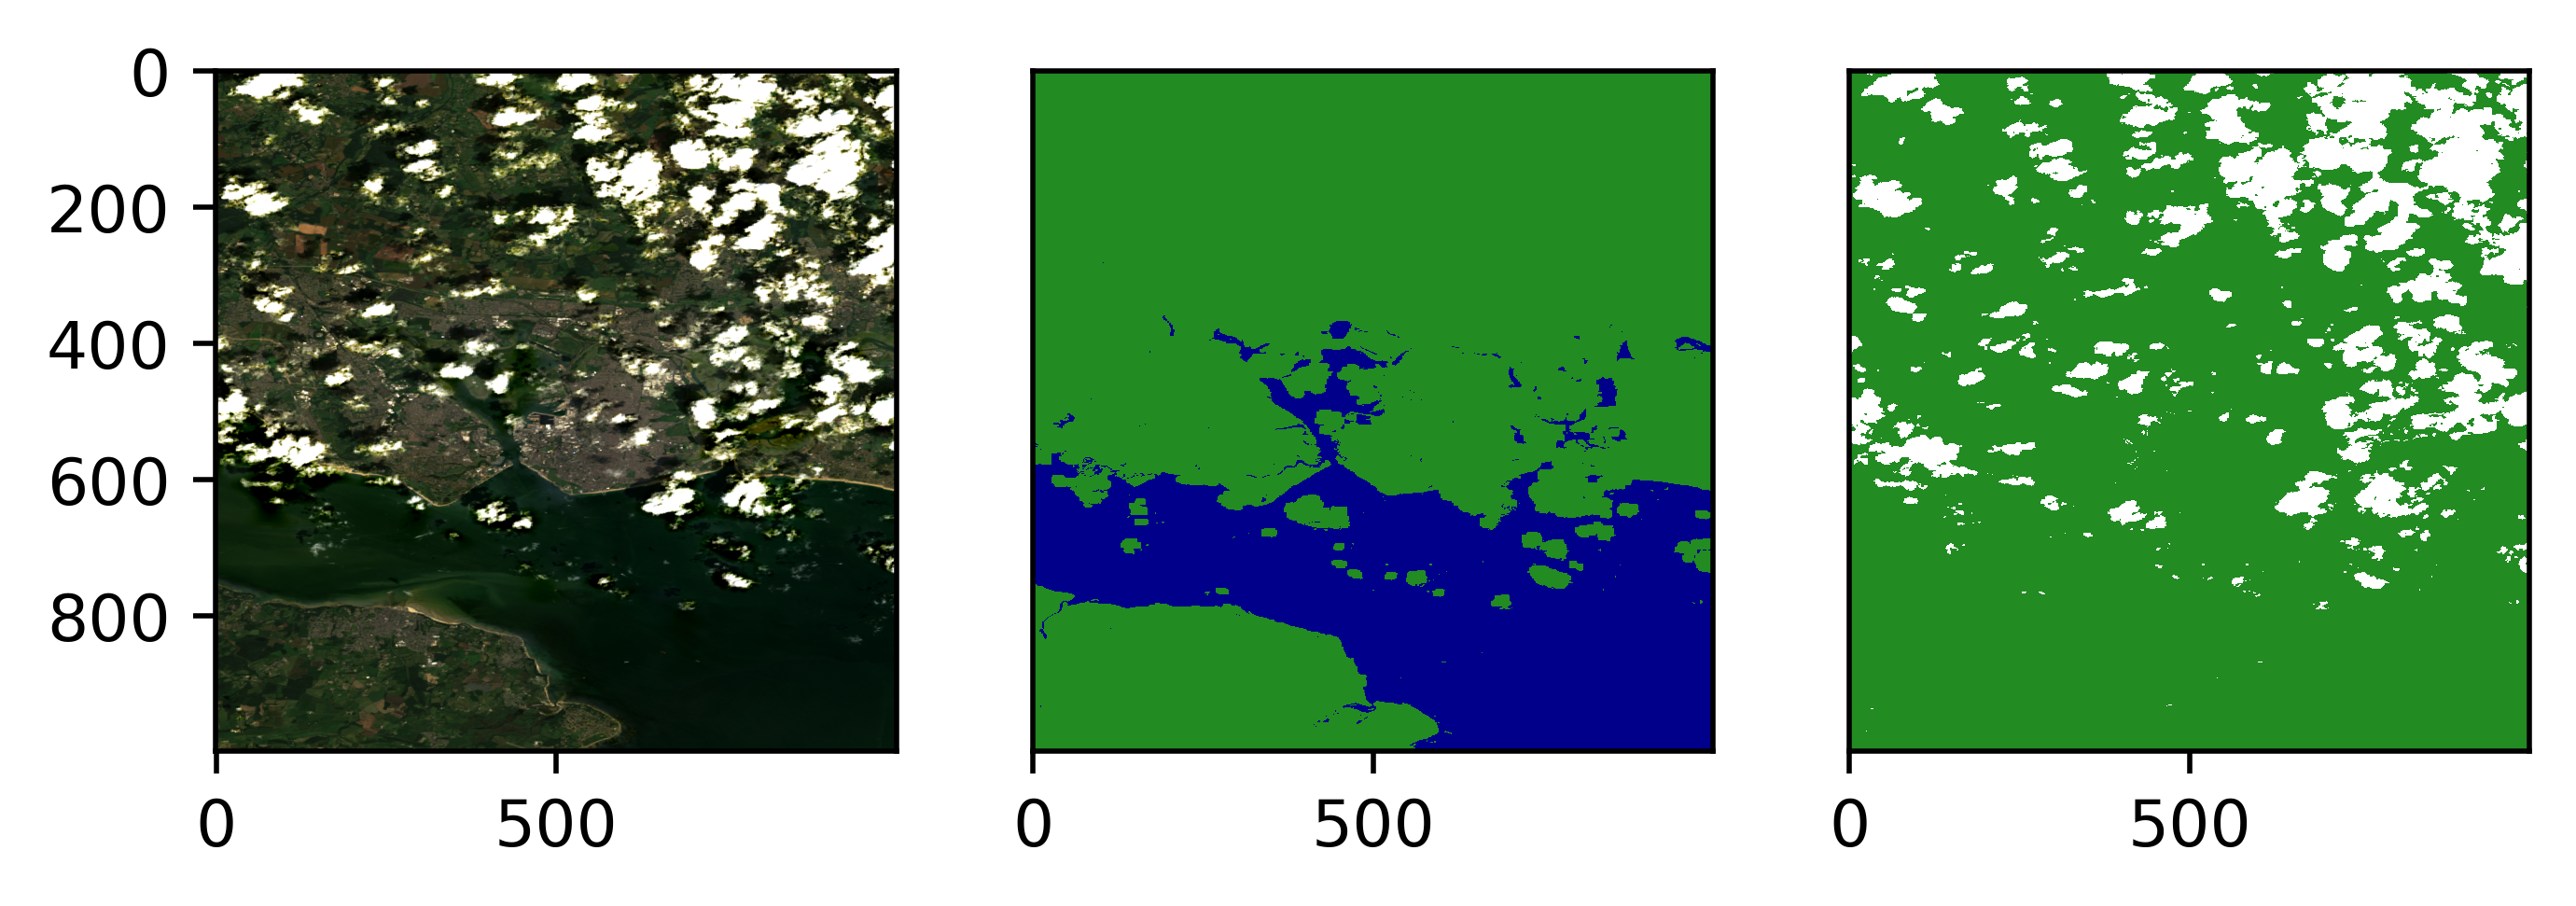

In [25]:
fig, ax = plt.subplots(1, 3, dpi=500)


ax[0].imshow(rbg_im)
ax[1].imshow(mask, cmap = mask_cmap, vmin=0, vmax=1)
ax[2].imshow(cloud, cmap = cloud_cmap, vmin=0, vmax=1)
ax[1].set_yticks([])
ax[2].set_yticks([])